# Jupyter Notebook for Illumination Flat Field

Required packages are: 
`numpy, astropy, photutils, jwst (pipeline)`

In [1]:
import os
import sys
import copy
import time
import numpy as np
from astropy import units as u
from astropy.nddata import Cutout2D, NDData
from astropy.stats import gaussian_sigma_to_fwhm
from astropy.table import Table
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.wcs.utils import pixel_to_skycoord
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy.visualization import simple_norm
from astropy.io import fits
from astropy.wcs import WCS

from photutils import CircularAperture, EPSFBuilder, find_peaks
from photutils.detection import DAOStarFinder, IRAFStarFinder
from photutils.psf import DAOGroup, IntegratedGaussianPRF, extract_stars, IterativelySubtractedPSFPhotometry
from photutils.background import MMMBackground, SExtractorBackground, ModeEstimatorBackground, MedianBackground
from photutils.background import MADStdBackgroundRMS
from photutils.centroids import centroid_2dg

%matplotlib inline
from matplotlib import style, pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as ticker

from jwst import datamodels

In [2]:
#This example will assume we have two NIRISS images: 

f1 = 'jw01086001001_01101_00021_nis_cal.fits'
f2 = 'jw01086001001_01101_00045_nis_cal.fits'

In [3]:
im1 = datamodels.open(f1)
data1 = copy.deepcopy(im1.data)
photmjsr1 = getattr(im1.meta.photometry,'conversion_megajanskys')
data_cps1 = data1/photmjsr1
print(photmjsr1)

0.37078890204429626


In [4]:
im2 = datamodels.open(f2)
data2 = copy.deepcopy(im2.data)
photmjsr2 = getattr(im2.meta.photometry,'conversion_megajanskys')
data_cps2 = data2/photmjsr2
print(photmjsr2)

0.37078890204429626


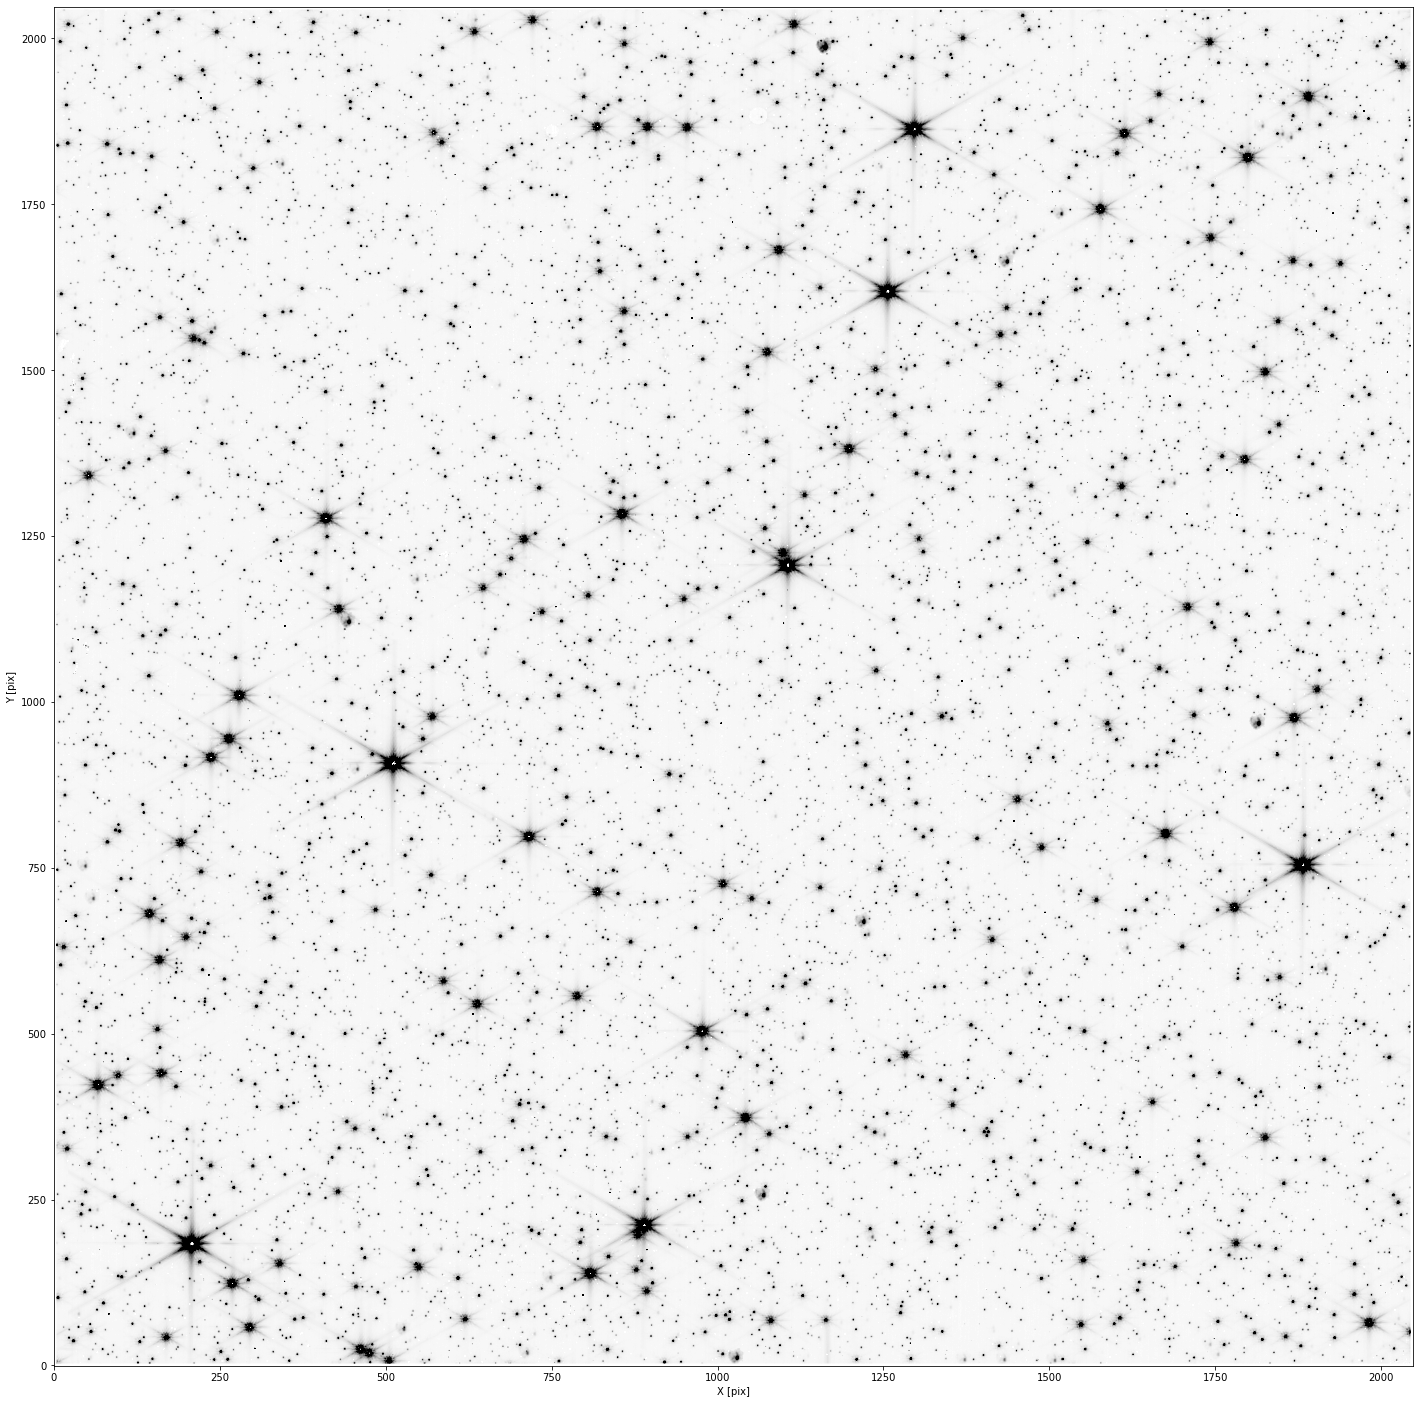

In [5]:
# Display one of the two images

plt.figure(figsize=(25,25))
ax = plt.subplot()
norm = simple_norm(data_cps1, 'sqrt', percent=99.)
plt.xlabel("X [pix]")
plt.ylabel("Y [pix]")
ax.imshow(data_cps1, norm=norm, cmap="Greys", origin='lower')

In [6]:
# Estimate background and identify stars to be used for building PSF via photutils tasks 
# The parameters below work generally well for NIRISS images

bkgrms = MADStdBackgroundRMS()
mmm_bkg = MMMBackground()
std1 = bkgrms(data_cps1)
bkg1 = mmm_bkg(data_cps1)
psf_stars1 = IRAFStarFinder(threshold=100*std1 + bkg1, fwhm=2.0, minsep_fwhm=7, 
                            roundlo=0.0, roundhi=0.6, sharplo=0.6, sharphi=1.4)
sources1 = psf_stars1(data_cps1)
print(std1,bkg1,len(sources1))

0.4934196078045637 0.9796515693911809 4446


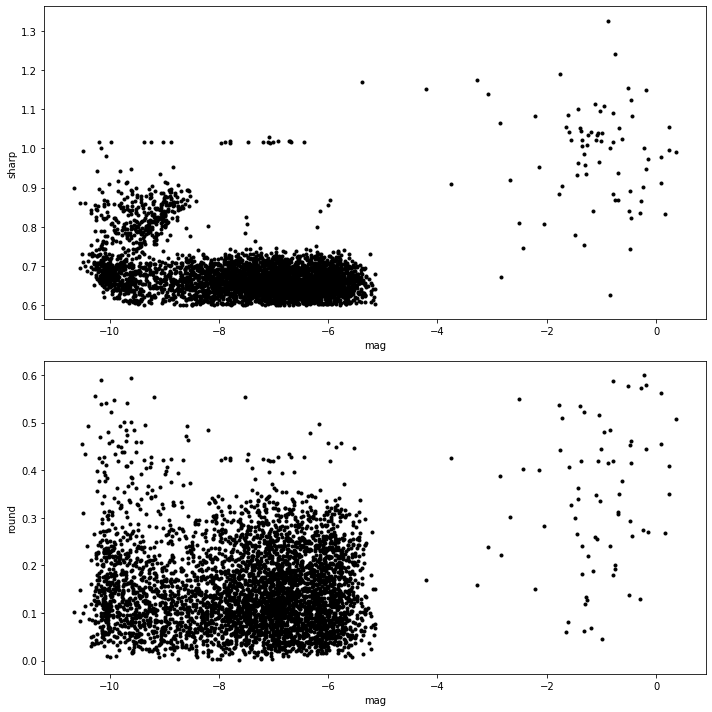

In [7]:
# Inspect plots like below to make sure we're picking up most of the stars while avoiding junks

fig, axs = plt.subplots(2,1, figsize=(10,10))
axs[0].plot(sources1['mag'], sources1['sharpness'], 'ko', markersize=3)
axs[0].set_xlabel('mag')
axs[0].set_ylabel('sharp')
axs[1].plot(sources1['mag'], sources1['roundness'], 'ko', markersize=3)
axs[1].set_xlabel('mag')
axs[1].set_ylabel('round')
fig.tight_layout()
plt.show()

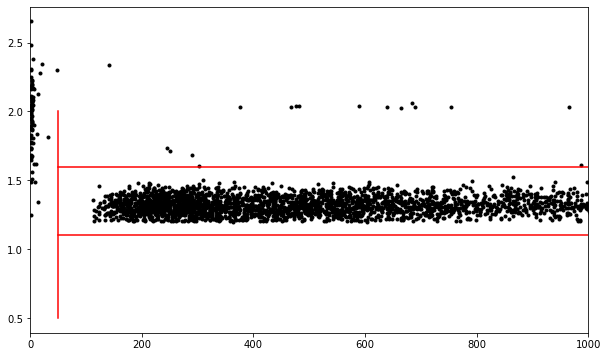

In [8]:
# Another plot we might want to inspect is the fwhm vs flux

plt.figure(figsize=(10,6))
plt.plot(sources1['flux'],sources1['fwhm'],'ko', markersize=3)
plt.xlim(0,1000)
plt.plot([50,50],[0.5,2],color='red')
plt.plot([50,1000],[1.6,1.6],color='red')
plt.plot([50,1000],[1.1,1.1],color='red')
plt.show()

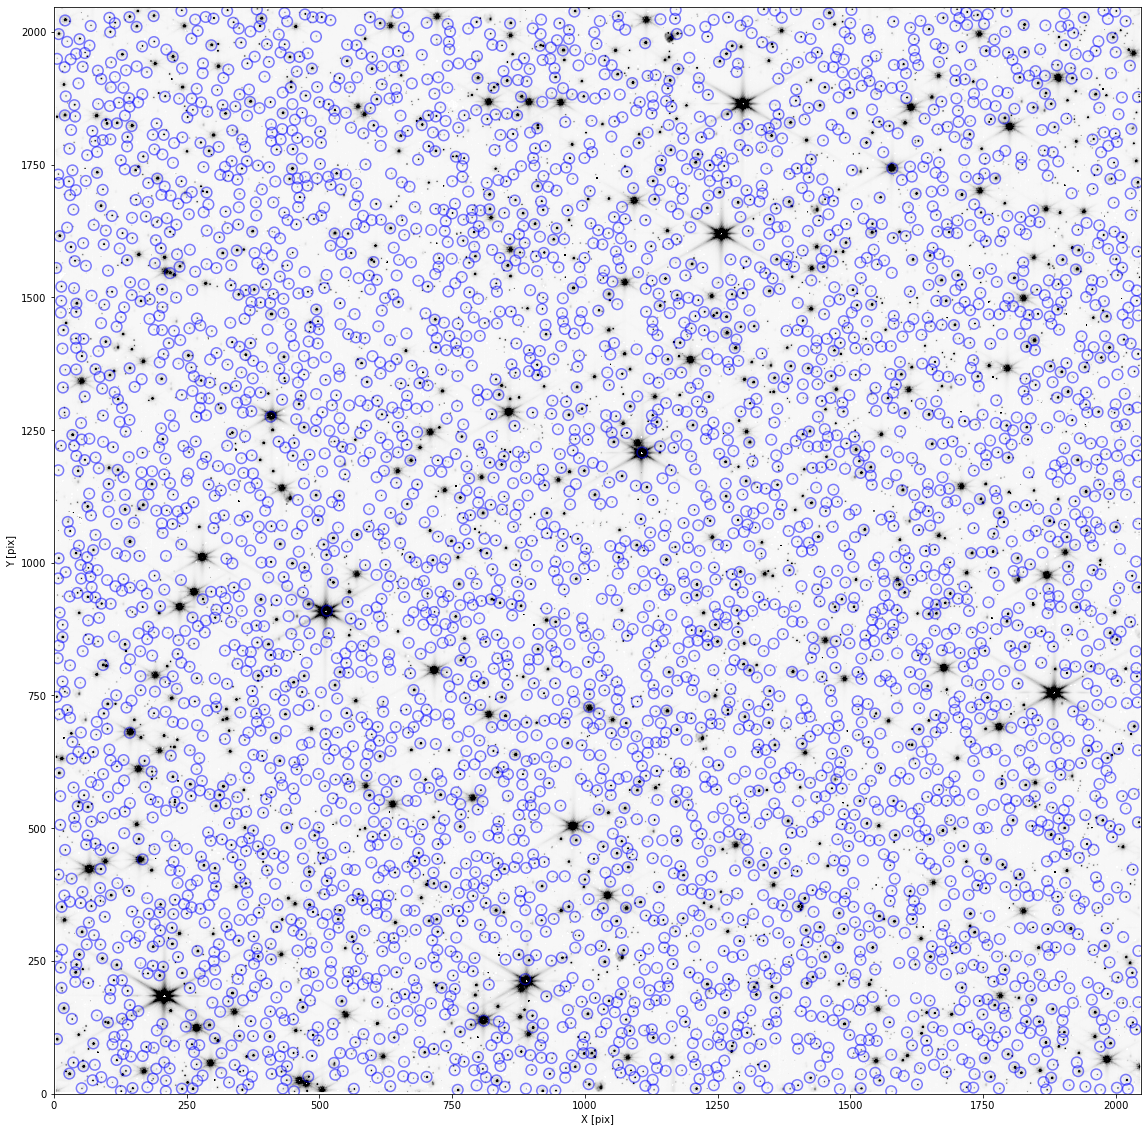

In [9]:
# From the plot above, good sources have 1.1<FWHM<1.6 pix and flux>50
# Apply these filters (or masks) and overplot the detected sources on the image to make sure we're dealing with actual stars

mask = (sources1['fwhm']>1.1) & (sources1['fwhm']<1.6) & (sources1['flux']>20) 
sources_masked1 = sources1[mask]
positions1 = np.transpose((sources_masked1['xcentroid'], sources_masked1['ycentroid']))
apertures1 = CircularAperture(positions1, r=10)
plt.figure(figsize=(20,20))
ax = plt.subplot()
plt.xlabel("X [pix]")
plt.ylabel("Y [pix]")
ax.imshow(data_cps1, norm=norm, cmap='Greys', origin='lower')
apertures1.plot(color='blue', lw=1.5, alpha=0.5)

In [10]:
# Okay, the source identification looks good above, so we'll do the same for the second image without inspection.

bkgrms = MADStdBackgroundRMS()
mmm_bkg = MMMBackground()
std2 = bkgrms(data_cps2)
bkg2 = mmm_bkg(data_cps2)
psf_stars2 = IRAFStarFinder(threshold=100*std2 + bkg2, fwhm=2.0, minsep_fwhm=7, 
                            roundlo=0.0, roundhi=0.6, sharplo=0.6, sharphi=1.4)
sources2 = psf_stars2(data_cps2)
mask = (sources2['fwhm']>1.1) & (sources2['fwhm']<1.6) & (sources2['flux']>20) 
sources_masked2 = sources2[mask]

In [11]:
# It's now time to build the ePSF using the sources selected above.
# Below is the preparation stage, that is, cutting out stamp images for each PSF star (use Cutout2D?), subtracting the ebackground, storing them in NDData, and extracting them.

size = 25
hsize = (size-1)/2
x1 = sources_masked1['xcentroid']
y1 = sources_masked1['ycentroid']
mask = ((x1>hsize) & (x1<(data_cps1.shape[1]-1-hsize)) & (y1>hsize) & (y1<(data_cps1.shape[0]-1-hsize)))
stars_tbl1 = Table()
stars_tbl1['x'] = x1[mask]
stars_tbl1['y'] = y1[mask]
data_bkgsub1 = data_cps1.copy()
data_bkgsub1 -=bkg1
nddata1 = NDData(data=data_bkgsub1)
stars1 = extract_stars(nddata1, stars_tbl1, size=size)

In [12]:
# The actual ePSF building stage - this will take a few minutes (a little over 2 mins on my laptop)

epsf_builder = EPSFBuilder(oversampling=4, maxiters=3, progress_bar=False)
tic = time.perf_counter()
epsf1, fitted_stars1 = epsf_builder(stars1)
toc = time.perf_counter()
print("Time elapsed:", toc - tic)

Time elapsed: 120.30527712999901


/Users/tsohn/anaconda3/envs/fpa/lib/python3.6/site-packages/astropy/visualization/stretch.py:285: RuntimeWarning: invalid value encountered in log
  np.log(values, out=values)


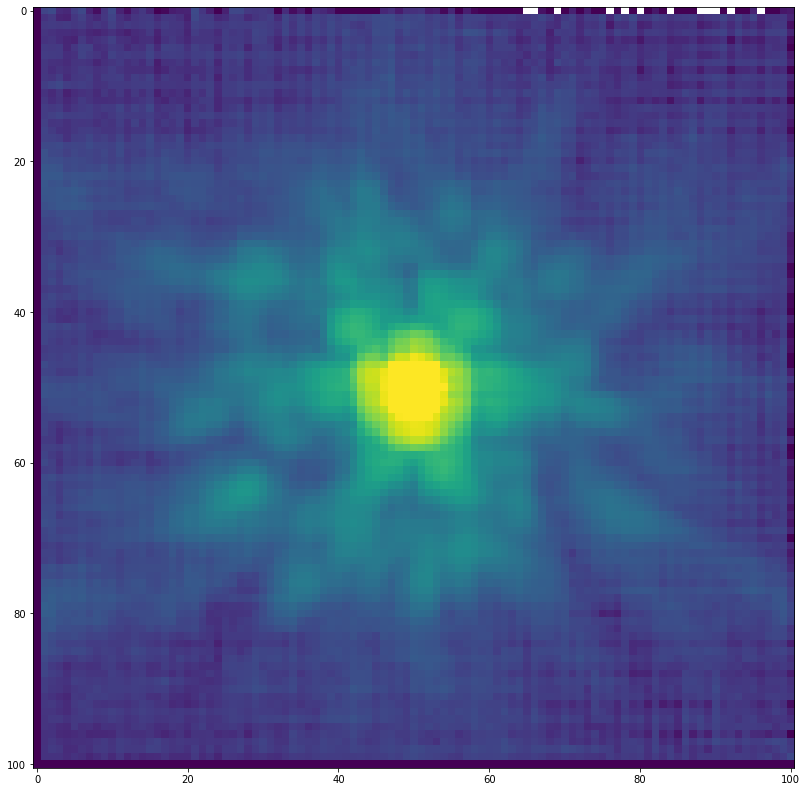

In [13]:
# Now inspect the ePSF built from above.

plt.figure(figsize=(14,14))
ax = plt.subplot()
norm_epsf = simple_norm(epsf1.data, 'log', percent=99.)
ax.imshow(epsf1.data, norm=norm_epsf)

In [14]:
# ePSF looks good, so we repeat the ePSF building stage for the second image

size = 25
hsize = (size-1)/2
x2 = sources_masked2['xcentroid']
y2 = sources_masked2['ycentroid']
mask = ((x2>hsize) & (x2<(data_cps1.shape[1]-1-hsize)) & (y2>hsize) & (y2<(data_cps1.shape[0]-1-hsize)))
stars_tbl2 = Table()
stars_tbl2['x'] = x2[mask]
stars_tbl2['y'] = y2[mask]
data_bkgsub2 = data_cps2.copy()
data_bkgsub2 -=bkg2
nddata2 = NDData(data=data_bkgsub2)
stars2 = extract_stars(nddata2, stars_tbl2, size=size)

epsf_builder = EPSFBuilder(oversampling=4, maxiters=3, progress_bar=False)
tic = time.perf_counter()
epsf2, fitted_stars2 = epsf_builder(stars2)
toc = time.perf_counter()
print("Time elapsed:", toc - tic)

Time elapsed: 123.23082760300895


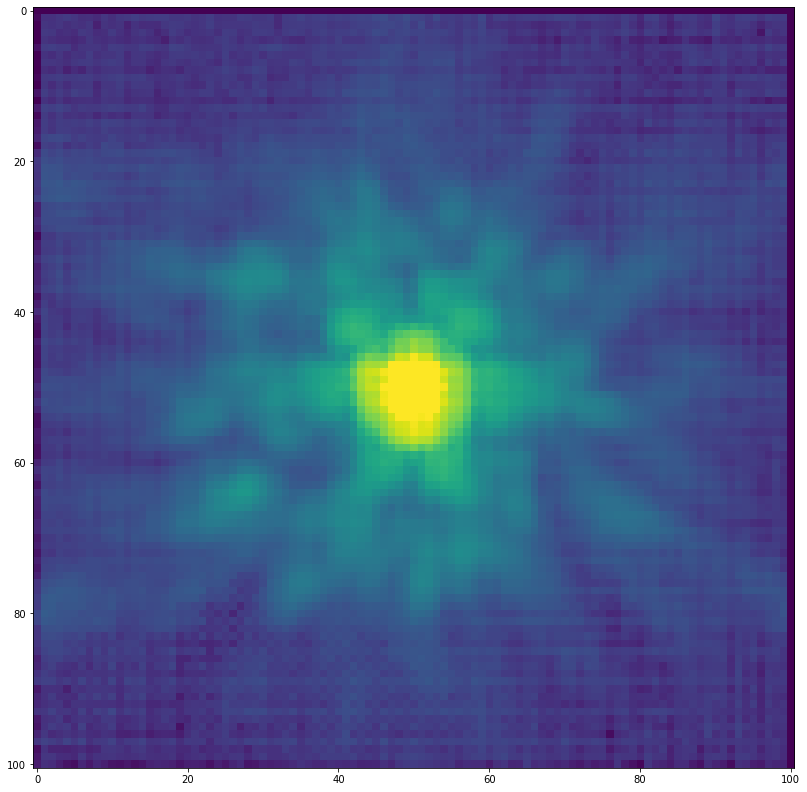

In [15]:
# And then inspect the ePSF built for the second image.

plt.figure(figsize=(14,14))
ax = plt.subplot()
norm_epsf = simple_norm(epsf2.data, 'log', percent=99.)
ax.imshow(epsf2.data, norm=norm_epsf)

In [39]:
###
### This step is omitted for the moment. Instead of scraping the bottom of the barrel to find fainter stars,
### I chose to just use the PSF star lists above for the source lists. Later, we may want to think about whether 
### photometering fainter stars will be worth the effort.
###
# Okay, now that we have ePSFs built for each image, we will do the ePSF photometry.
# To do this, we first identify sources using a more generous condition (10-sigma detection instead of 50)
# Then the sources are grouped into appropriate sizes.
#
#iraffind1 = IRAFStarFinder(threshold=10*std1 + bkg1, fwhm=2.0, minsep_fwhm=1.0, 
#                          roundlo=0.0, roundhi=0.6, sharplo=0.6, sharphi=1.4)
#allsources1 = iraffind1(data_cps1)
#
#iraffind2 = IRAFStarFinder(threshold=10*std2 + bkg2, fwhm=2.0, minsep_fwhm=1.0, 
#                           roundlo=0.0, roundhi=0.6, sharplo=0.6, sharphi=1.4)
#allsources2 = iraffind2(data_cps2)

In [16]:
# The actual ePSF photometry step. This is the most computationally intensive stage of this notebook.

daogroup = DAOGroup(5.0*1.8)
fitter = LevMarLSQFitter()

psf_model1 = epsf1.copy()

tic = time.perf_counter()
phot1 = IterativelySubtractedPSFPhotometry(finder=psf_stars1, group_maker=daogroup,
                                           bkg_estimator=mmm_bkg, psf_model=psf_model1,
                                           fitter=fitter,
                                           niters=1, fitshape=(11,11), aperture_radius=3)
result_tab1 = phot1(data_cps1)
toc = time.perf_counter()
print("Time elapsed:", toc - tic, "Number of sources detected in image:", len(result_tab1))

Time elapsed: 131.44447065099666 Number of sources detected in image: 4446


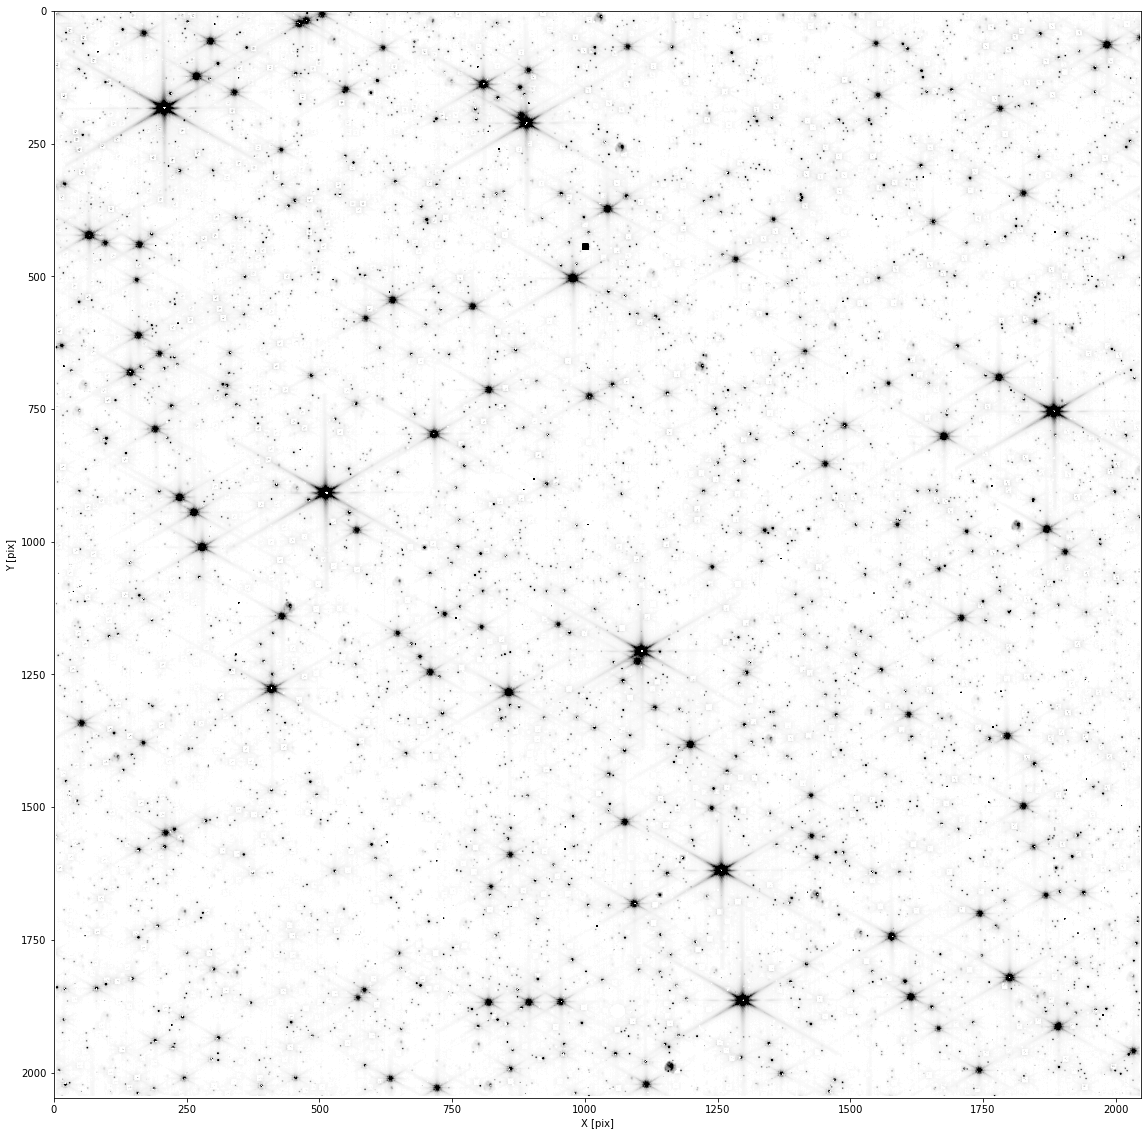

In [17]:
# Inpsect the PSF-subtracted image

diff1 = phot1.get_residual_image()
plt.figure(figsize=(20,20))
ax = plt.subplot()
plt.xlabel("X [pix]")
plt.ylabel("Y [pix]")
ax.imshow(diff1, norm=norm, cmap='Greys')

In [18]:
# Okay, PSF-subtracted image looks good, so we'll proceed with the other image

psf_model2 = epsf2.copy()

tic = time.perf_counter()
phot2 = IterativelySubtractedPSFPhotometry(finder=psf_stars2, group_maker=daogroup,
                                           bkg_estimator=mmm_bkg, psf_model=psf_model2,
                                           fitter=fitter,
                                           niters=1, fitshape=(11,11), aperture_radius=3)
result_tab2 = phot1(data_cps2)
toc = time.perf_counter()
print("Time elapsed:", toc - tic, "Number of sources detected in image:", len(result_tab2))

Time elapsed: 133.65979508399323 Number of sources detected in image: 4484


In [21]:
# Rename tables and add magnitude columns

t1 = result_tab1
t2 = result_tab2

t1['mag'] = -2.5*np.log10(t1['flux_fit'])+25. # Magnitude zero point arbitrarily set at 25
t1['mag_err'] = -1.0857*t1['flux_unc']/t1['flux_fit']

t2['mag'] = -2.5*np.log10(t2['flux_fit'])+25. # Magnitude zero point arbitrarily set at 25
t2['mag_err'] = -1.0857*t2['flux_unc']/t2['flux_fit']

/Users/tsohn/anaconda3/envs/fpa/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':
/Users/tsohn/anaconda3/envs/fpa/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log10
  del sys.path[0]


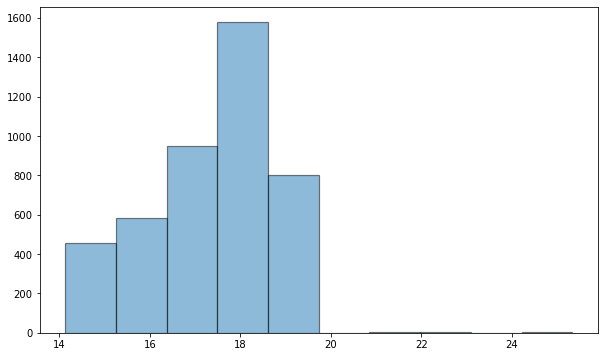

In [22]:
plt.figure(figsize=(10,6))
plt.hist(t1['mag'], alpha=0.5, histtype='bar', edgecolor='black', linewidth=1.2)
plt.show()

In [69]:
#
# Convert the detected positions into sky coordinates (RA, Dec) in degrees
#

fn1 = fits.open(f1)
w1 = WCS(fn1[1].header)
c1 = w1.pixel_to_world(t1['x_fit'], t1['y_fit'])
t1['ra_deg'], t1['dec_deg'] = c1.ra.value, c1.dec.value

fn2 = fits.open(f2)
w2 = WCS(fn2[1].header)
c2 = w2.pixel_to_world(t2['x_fit'], t2['y_fit'])
t2['ra_deg'], t2['dec_deg'] = c2.ra.value, c2.dec.value

In [70]:
# At this stage, let's save the resulting photometry table to files so I don't have to 
# repeat all the steps above in case something goes wrong with this session

t1.write('jw01086001001_01101_00021_nis_cal_photutils.fits', format='fits', overwrite=True)
t2.write('jw01086001001_01101_00045_nis_cal_photutils.fits', format='fits', overwrite=True)

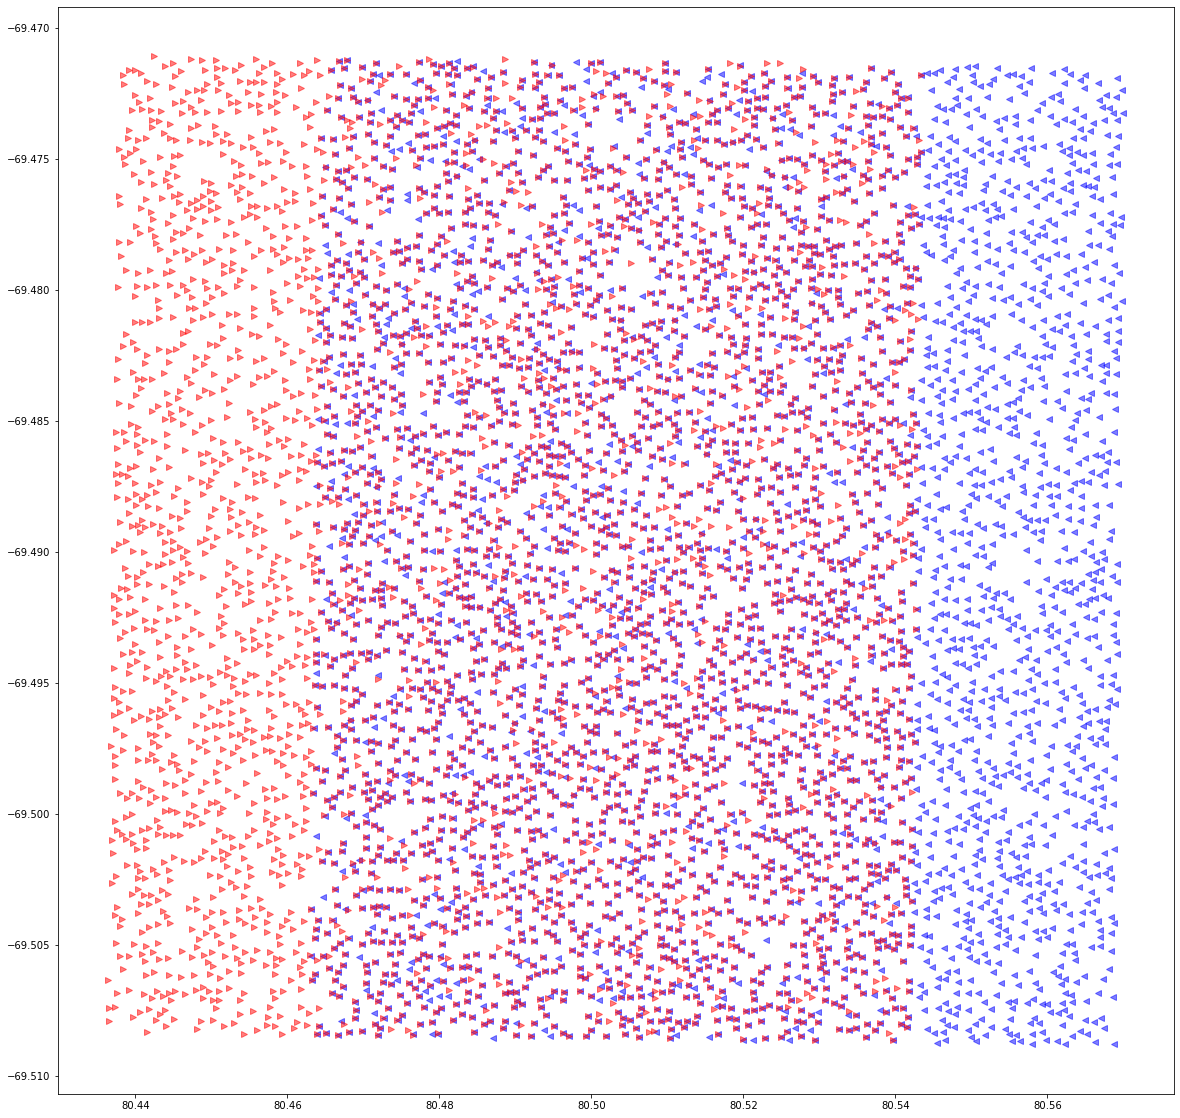

In [73]:
# Let's take a look at how the sky coordinates look like for each catalog
plt.figure(figsize=(20,20))
plt.plot(t1['ra_deg'], t1['dec_deg'],'b<',alpha=0.5)
plt.plot(t2['ra_deg'], t2['dec_deg'],'r>',alpha=0.5)
plt.show()

In [46]:
# Now let's do the coordinate-based crossmatching
# For this, we use the simple match_coordinates_sky method from astropy.coordinates

idx, d2d, d3d = match_coordinates_sky(c2, c1)

### Note!!!: idx is the index of c1

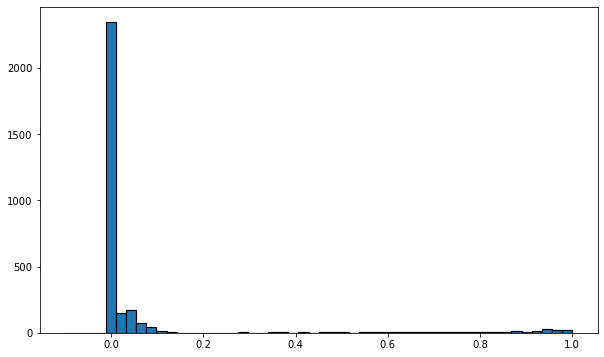

In [76]:
# Inspect the distance between matched sources to find out how to select good sources.

plt.figure(figsize=(10,6))
plt.hist(d2d.arcsecond, histtype='bar', edgecolor='black', linewidth=1.2, bins=50, range=(-0.1,1))
plt.show()

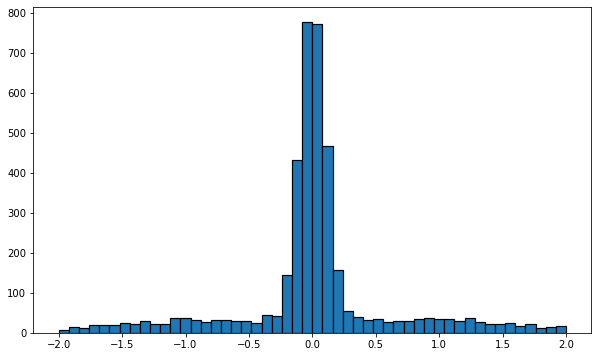

In [68]:
# Also inspect difference in magnitudes.

dmag = t2['mag'] - t1['mag'][idx]
plt.figure(figsize=(10,6))
plt.hist(dmag, histtype='bar', edgecolor='black', linewidth=1.2, bins=50, range=(-2,2))
plt.show()

In [77]:
t1.colnames

['x_0',
 'x_fit',
 'y_0',
 'y_fit',
 'flux_0',
 'flux_fit',
 'id',
 'group_id',
 'flux_unc',
 'x_0_unc',
 'y_0_unc',
 'iter_detected',
 'mag',
 'mag_err',
 'ra_deg',
 'dec_deg']

In [83]:
# First, create a crossmatched catalog that includes ALL sources. 
# We'll do the filtering later.

t = Table()
t['ra_deg_cat1']  = t1['ra_deg'][idx]
t['dec_deg_cat1'] = t1['dec_deg'][idx]
t['x_fit_cat1']   = t1['x_fit'][idx]
t['y_fit_cat1']   = t1['y_fit'][idx]
t['mag_cat1']     = t1['mag'][idx]
t['magerr_cat1']  = t1['mag_err'][idx]
t['ra_deg_cat2']  = t2['ra_deg']
t['dec_deg_cat2'] = t2['dec_deg']
t['x_fit_cat2']   = t2['x_fit']
t['y_fit_cat2']   = t2['y_fit']
t['mag_cat2']     = t2['mag']
t['magerr_cat2']  = t2['mag_err']
t['sep2d_arcsec']   = d2d.arcsecond

t.colnames

['ra_deg_cat1',
 'dec_deg_cat1',
 'x_fit_cat1',
 'y_fit_cat1',
 'mag_cat1',
 'magerr_cat1',
 'ra_deg_cat2',
 'dec_deg_cat2',
 'x_fit_cat2',
 'y_fit_cat2',
 'mag_cat2',
 'magerr_cat2',
 'sep2d_arcsec']

In [86]:
# Now filter out the bad matches and write the crossmatched catalog to a FITS table

mask = (t['sep2d_arcsec'] < 0.3)
t_filtered = t[mask]
t_filtered.write('crossmatched.fits', format='fits', overwrite=True)